# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Data Files

In [3]:
import glob

# Define a function to parse C++-style complex numbers
def parse_cpp_complex(s):
    return complex(*map(float, s.strip("()").split(',')))


# Find all text files starting with "out"
fileList = glob.glob("out*.txt") 

# Organize the data into arrays
dataArr = []
for file in fileList:
    _, tnum, N, n0, sig, k0 = file.split("-")
    tnum, N, n0, sig, k0 = int(tnum), int(N), int(n0), int(sig), float(k0[:-4])
    
    # Load the file as an array of strings
    data = np.genfromtxt(file, dtype=str)
    data = np.array([[parse_cpp_complex(num) for num in data[i]] for i in range(len(data))], dtype=np.complex128)

    dataArr += [(tnum, N, n0, sig, k0, data)]



# Find all text files starting with "time"
fileList = glob.glob("time*.txt") 

# Get time data
ttArr, rrArr, uuArr = [], [], []
for fileName in fileList:
    with open(fileName, "r") as file:
        text = file.read().split("\n")
        text = [item for item in text if len(item) > 2]

    tt, rr, uu = [], [], []
    for index in range(len(text) // 4):
        index *= 4
        tt += [int(text[index].split("=")[-1])]
        rr += [float(text[index + 1].split("m")[-1][:-1])]
        uu += [float(text[index + 2].split("m")[-1][:-1])]

    ttArr += [tt]
    rrArr += [rr]
    uuArr += [uu]

ttArr = np.array(ttArr)
rrArr = np.array(rrArr)
uuArr = np.array(uuArr)

# Visualization

In [4]:
# Imports
from matplotlib import animation
from matplotlib.animation import PillowWriter

from PIL import Image


#  Update rule for the video
timestep = 0
def update(frame, line, ax, data):
    global timestep

    # Update time
    timestep += 1
    ax.set_title(f"Wave function at time step {timestep}.")  # Use ax.set_title for better performance

    # Update line data
    line.set_ydata(np.abs(data[frame, :]))

    return line,


# Make the video
def makeGIF(dataTuple: tuple, maxFrames: int = 100):
    global timestep

    # Extract the data
    _, N, n0, sig, k0, data = dataTuple

    # Use only every skip item
    skip = int(len(data[:, 0]) / maxFrames) + 1
    data = data[0::skip, :]

    # Start the plot
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    ax.grid(True)
    ax.set_title("Wave function at time step 0.")
    ax.set_xlabel("Position along the lattice (n)")
    ax.set_ylabel("Modulus of wave function $|\\psi(n, t)|$")

    # First frame
    x_values = np.arange(0, N)
    line, = ax.plot(x_values, np.abs(data[0, :]), c="b") 

    # Reset timestep
    timestep = 0

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(data[:, 0]), fargs=(line, ax, data), interval=100)

    # Save animation
    ani.save(f"wave-{N}-{n0}-{sig}-{k0}.gif", writer="pillow")
    plt.close()

# Wave Function

In [5]:
# See wave functions
for item in dataArr:
    makeGIF(item)

# Parallelization

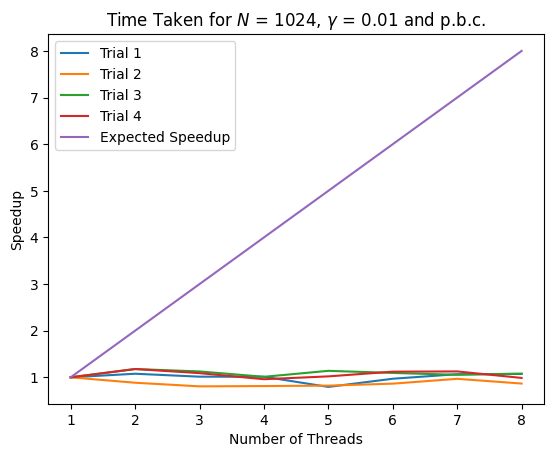

In [6]:
plt.title(f"Time Taken for $N$ = {1024}, $\\gamma$ = {0.01} and {'p.' if True else 'o.'}b.c.")
for tt, rr, index in zip(ttArr, rrArr, range(0, len(ttArr))):
    plt.plot(tt, rr[0] / rr, label=f"Trial {index+1}")

plt.plot(tt, tt, label="Expected Speedup")
plt.xlabel("Number of Threads")
plt.ylabel("Speedup")
plt.legend()